# Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will begin with an untuned model.

In [5]:
gbm_untuned = GradientBoostingClassifier(random_state=2025)
gbm_untuned.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [6]:
y_train_pred = gbm_untuned.predict(X_train)
y_test_pred = gbm_untuned.predict(X_test)

Training Set Metrics:


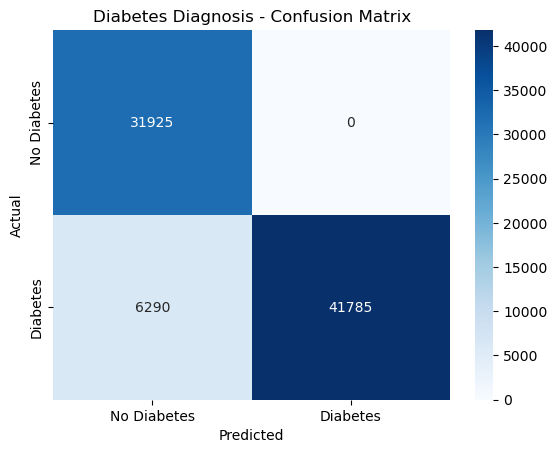

Accuracy: 0.921375
Precision: 1.0
Recall: 0.8691627665106604
F1 Score: 0.9300022256843979


Test Set Metrics:


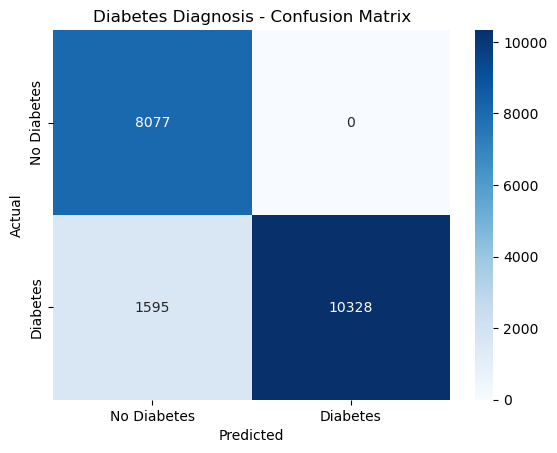

Accuracy: 0.92025
Precision: 1.0
Recall: 0.8662249433867315
F1 Score: 0.9283178284122062


In [7]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This is the first model that got less than 1596 false negatives, albeit only one less. Let us see if we can make it any better. We set n_iter to 50 and cv to 3 in order to get decent results while avoiding enormous runtimes.

In [8]:
gbm = GradientBoostingClassifier(random_state=2025)

parameters = {
    'n_estimators': np.arange(200, 1001, 200),
    'max_features': ['sqrt', None],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
}

gbm_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=parameters,
    n_iter=50,
    scoring='f1',
    cv=3,
    random_state=2025,
    n_jobs=-1,
    verbose=1
)

gbm_search.fit(X_train, y_train)

n_estimators = gbm_search.best_params_['n_estimators']
max_features = gbm_search.best_params_['max_features']
subsample = gbm_search.best_params_['subsample']
max_depth = gbm_search.best_params_['max_depth']
min_samples_leaf = gbm_search.best_params_['min_samples_leaf']
min_samples_split = gbm_search.best_params_['min_samples_split']
learning_rate = gbm_search.best_params_['learning_rate']

gbm_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'subsample': 0.9,
 'n_estimators': np.int64(600),
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 7,
 'learning_rate': 0.01}

In [5]:
gbm1 = GradientBoostingClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    subsample=subsample,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    learning_rate=learning_rate,
    random_state=2025
)

gbm1.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.01
,n_estimators,600
,subsample,0.9
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,7
,min_impurity_decrease,0.0
,init,None


In [6]:
y_train_pred = gbm1.predict(X_train)
y_test_pred = gbm1.predict(X_test)

Training Set Metrics:


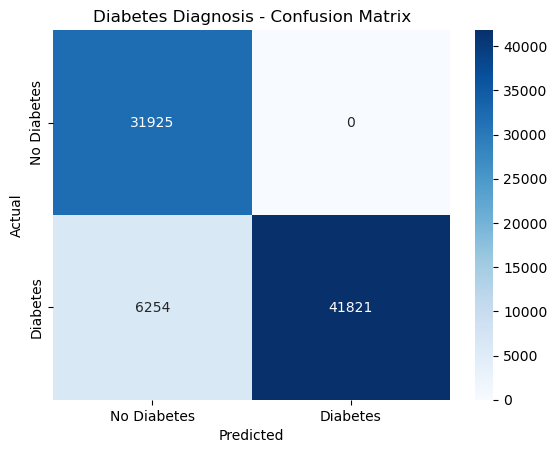

Accuracy: 0.921825
Precision: 1.0
Recall: 0.8699115964638585
F1 Score: 0.9304307199430453


Test Set Metrics:


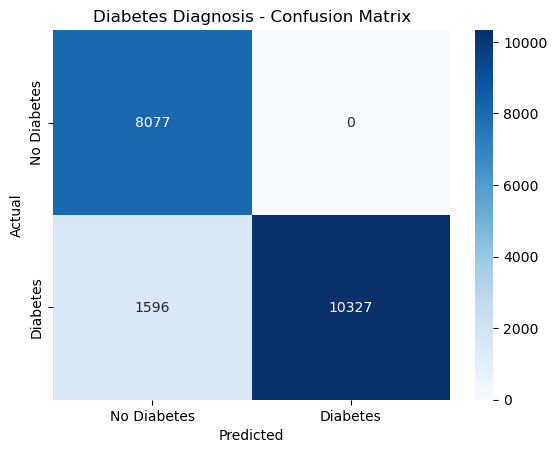

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [7]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

The model actually got worse again. Let's do a grid search.

In [4]:
gbm = GradientBoostingClassifier(random_state=2025)

parameters = {
    'n_estimators': [500, 600, 700],
    'max_features': [None],
    'subsample': [0.9],
    'max_depth': [7],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'learning_rate': [0.02, 0.01, 0.005, 0.001],
}

gbm_search = GridSearchCV(
    estimator=gbm,
    param_grid=parameters,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

gbm_search.fit(X_train, y_train)

n_estimators = gbm_search.best_params_['n_estimators']
max_features = gbm_search.best_params_['max_features']
subsample = gbm_search.best_params_['subsample']
max_depth = gbm_search.best_params_['max_depth']
min_samples_leaf = gbm_search.best_params_['min_samples_leaf']
min_samples_split = gbm_search.best_params_['min_samples_split']
learning_rate = gbm_search.best_params_['learning_rate']

gbm_search.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'learning_rate': 0.01,
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600,
 'subsample': 0.9}

We end up with the same parameters, so there is no need for testing performance again. We will try to optimize the threshold instead.

In [8]:
y_train_probs = gbm1.predict_proba(X_train)[:, 1]
y_test_probs = gbm1.predict_proba(X_test)[:, 1]

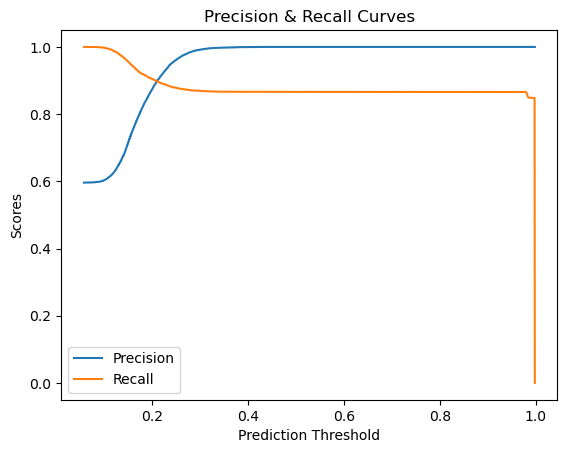

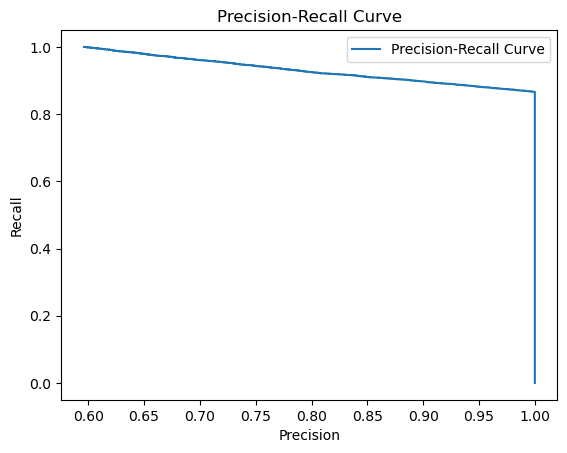

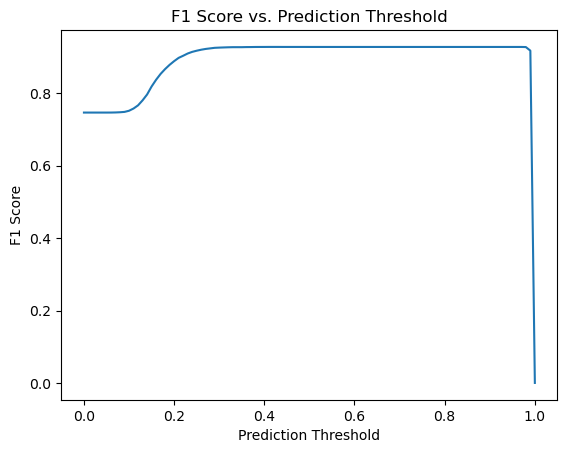

np.float64(0.41000000000000003)

In [9]:
thresh = optimize_threshold(y_test, y_test_probs)
thresh

In [10]:
preds_train = y_train_probs >= thresh
preds_test = y_test_probs >= thresh

Training Set Metrics with Optimized Threshold:


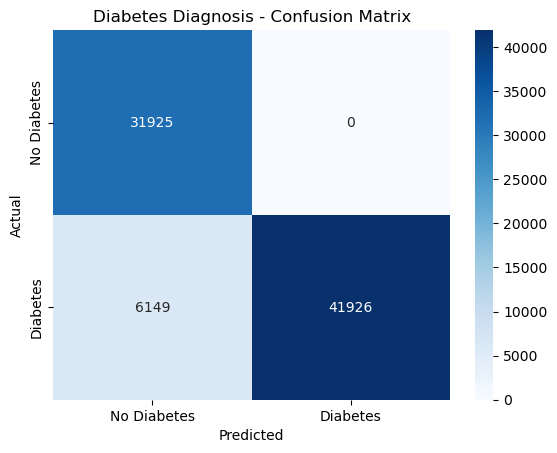

Accuracy: 0.9231375
Precision: 1.0
Recall: 0.8720956838273531
F1 Score: 0.9316785369051455


Test Set Metrics with Optimized Threshold:


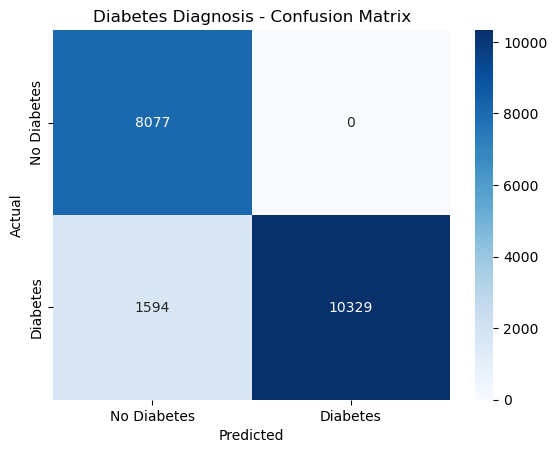

Accuracy: 0.9203
Precision: 1.0
Recall: 0.86630881489558
F1 Score: 0.9283659895739709


In [11]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

This improves the model marginally. Our test set false negatives dropped from 1596 to 1594. Let's take a look at the roc curve now.

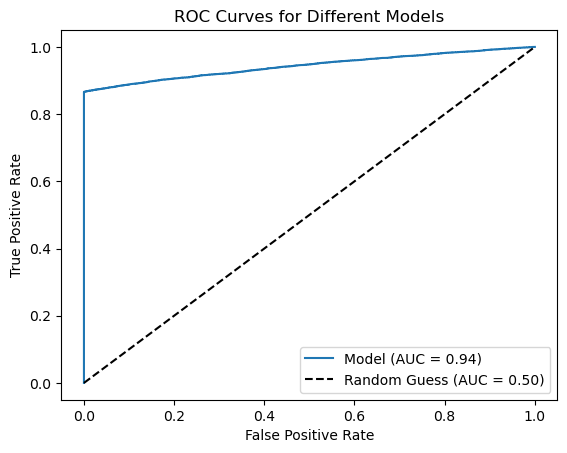

In [12]:
plot_roc_curve(y_test, y_test_probs)

It looks the same as that of the few previous models. Let's save the model.

In [13]:
joblib.dump(gbm1, "../models/gradient_boosting_model.joblib")

['../models/gradient_boosting_model.joblib']